In [94]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import scoobpsf.psds as psds
import lina

import purepyindi
from purepyindi import INDIClient
client0 = INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

from scoobpy import utils as scoob_utils
from magpyx.utils import ImageStream

wavelength = 633e-9


INFO:purepyindi2.transports:Connected to localhost:7624


In [2]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [47]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='nsvcam', dm_channel='dm00disp05')

In [4]:
I.set_fib_atten(5, client)

Set the fiber attenuation to 5.0


In [7]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


# Aquire LLOWFSC reference image

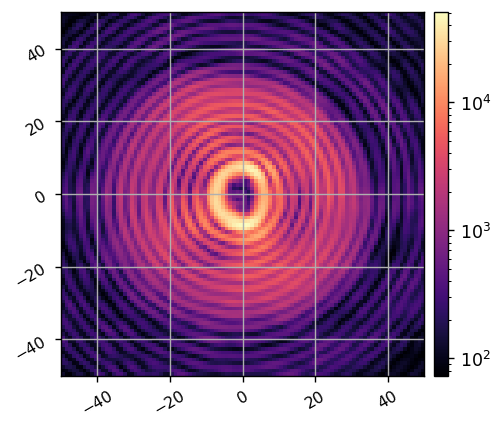

In [80]:
I.x_shift_locam = 8
I.y_shift_locam = 2
I.Nframes_locam = 10

I.att_ref = 5
I.texp_locam_ref = 0.003
I.gain_locam_ref = 1

I.att = 5
I.texp_locam = 0.003
I.gain_locam = 1
I.return_ni_locam = True

ref_im = I.stack_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

# Perform the calibration for LLOWFSC

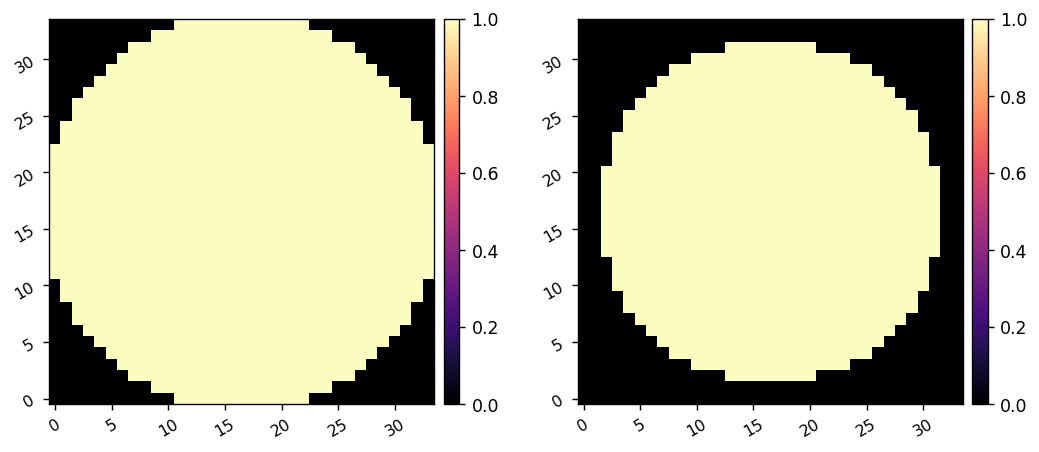

In [54]:
imshow2(I.dm_mask, I.dm_pupil_mask)

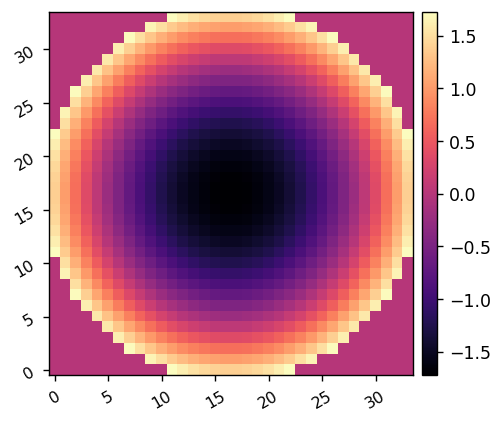

In [59]:
Nmodes = 20
dm_zernikes = lina.utils.create_zernike_modes(I.dm_mask, nmodes=Nmodes, remove_modes=1)
imshow1(dm_zernikes[2])

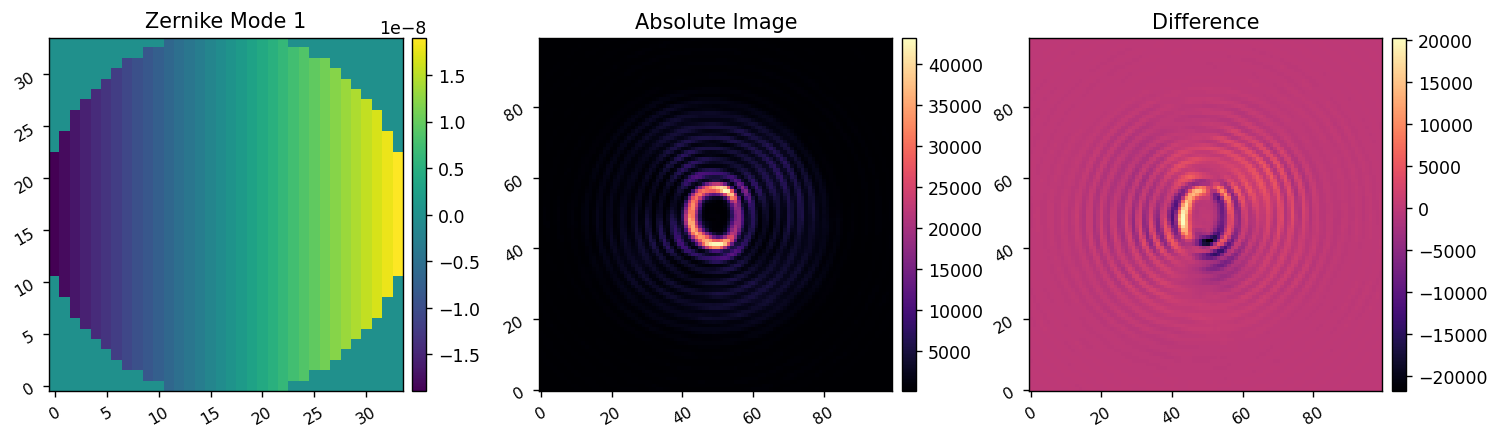

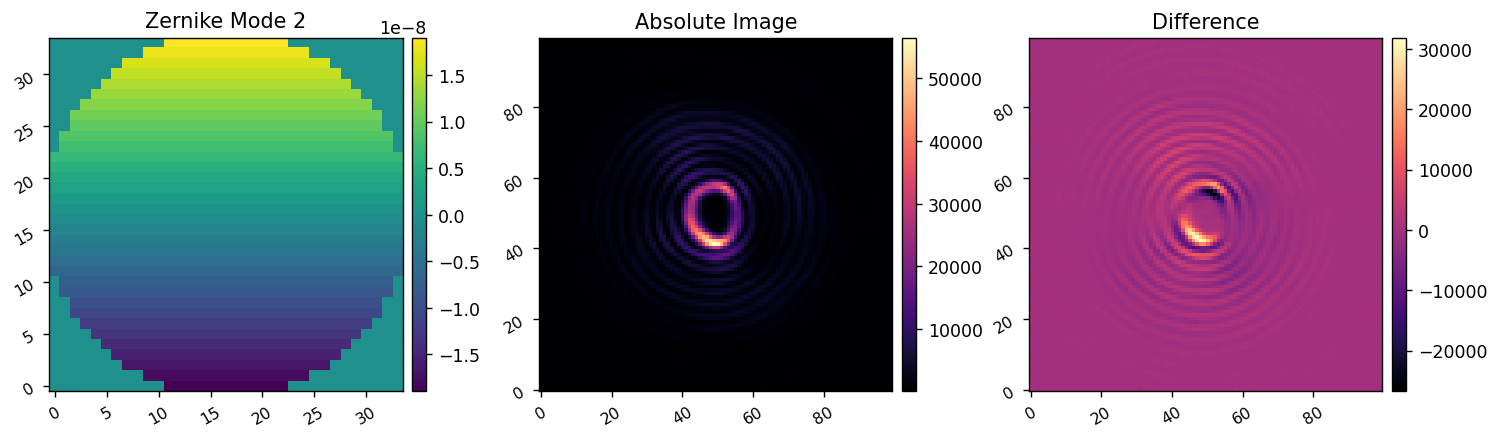

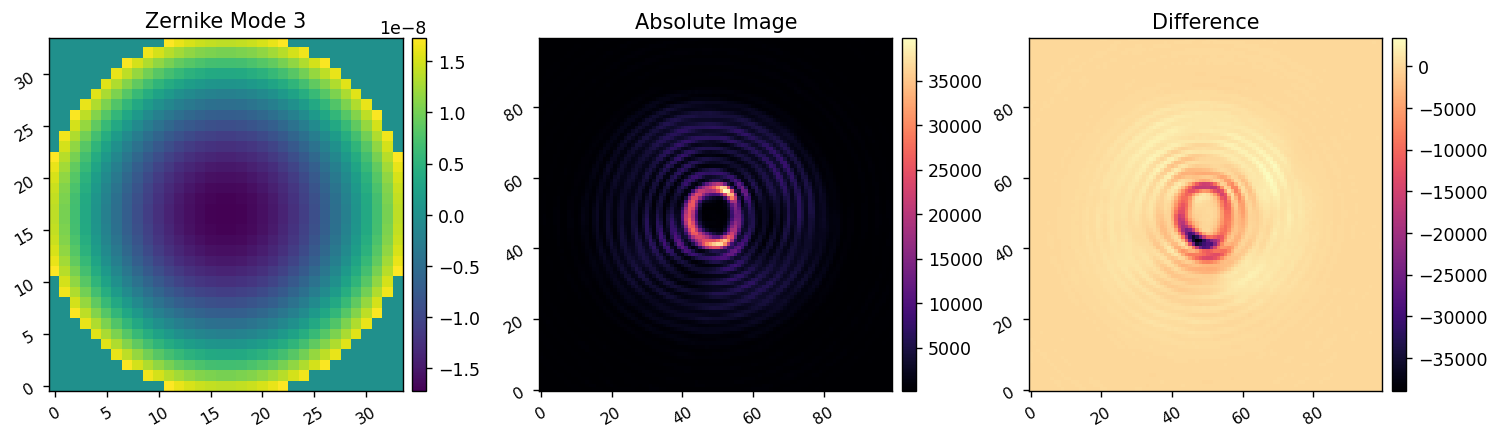

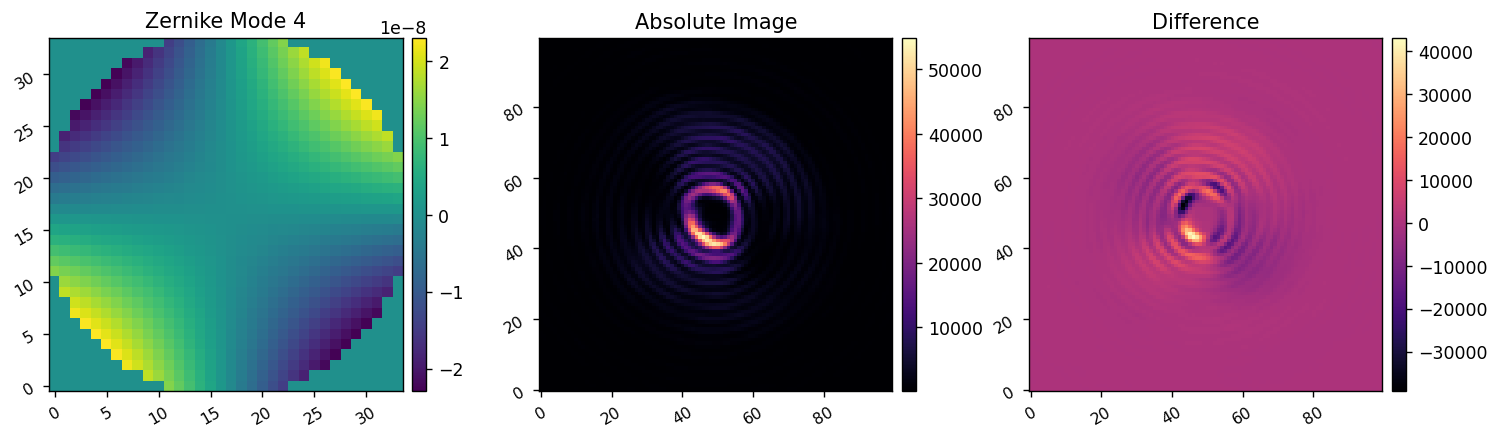

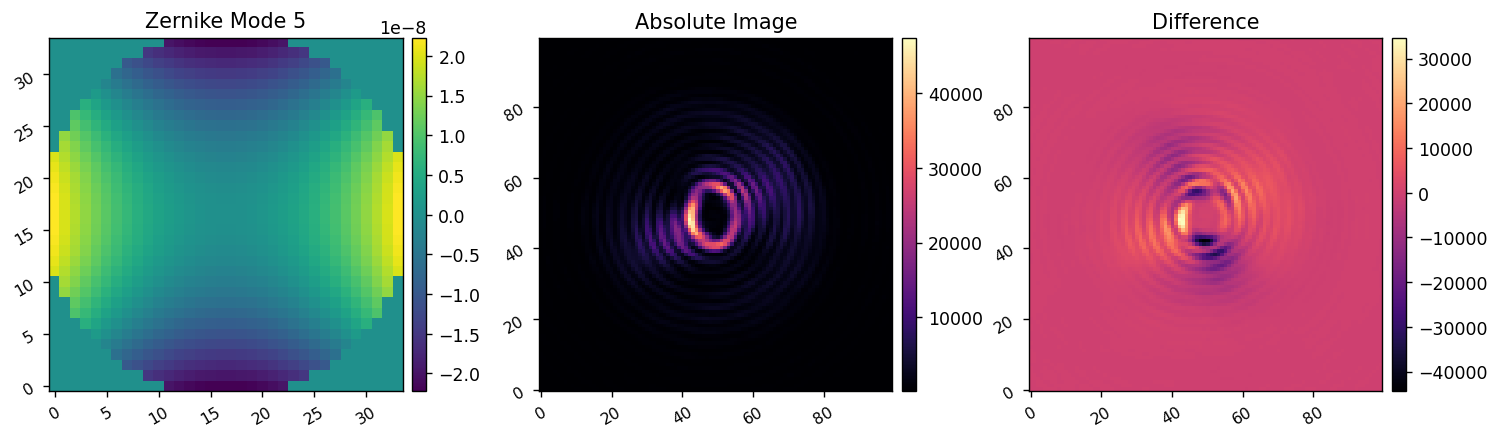

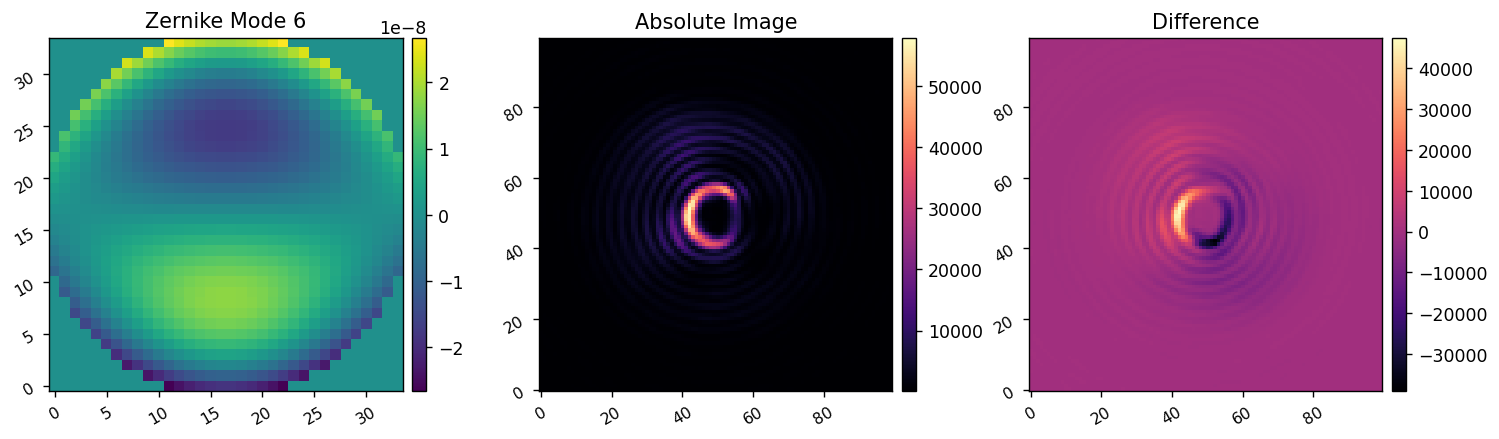

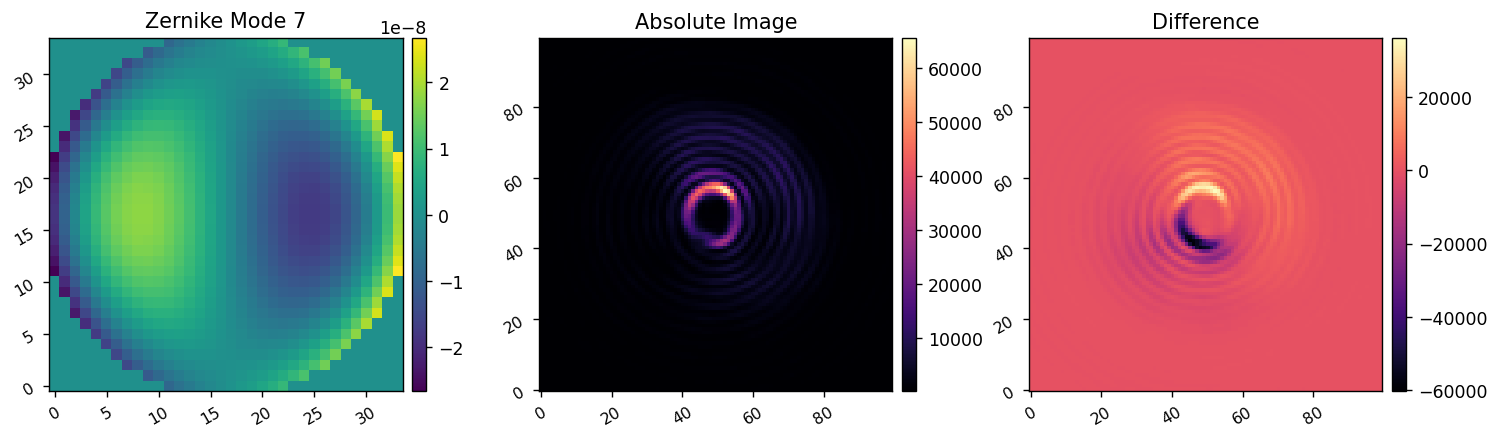

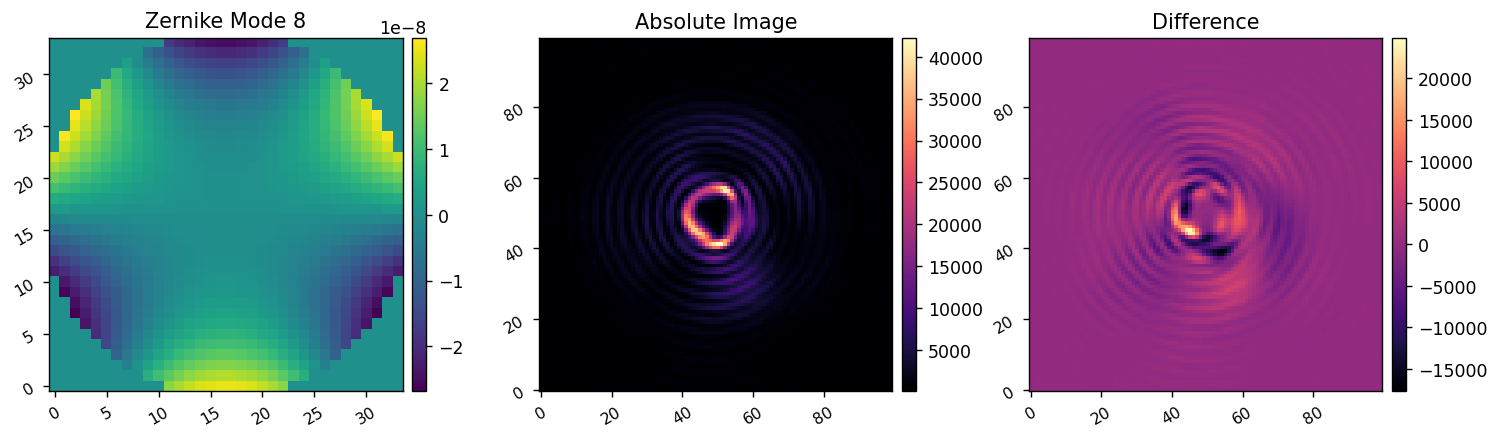

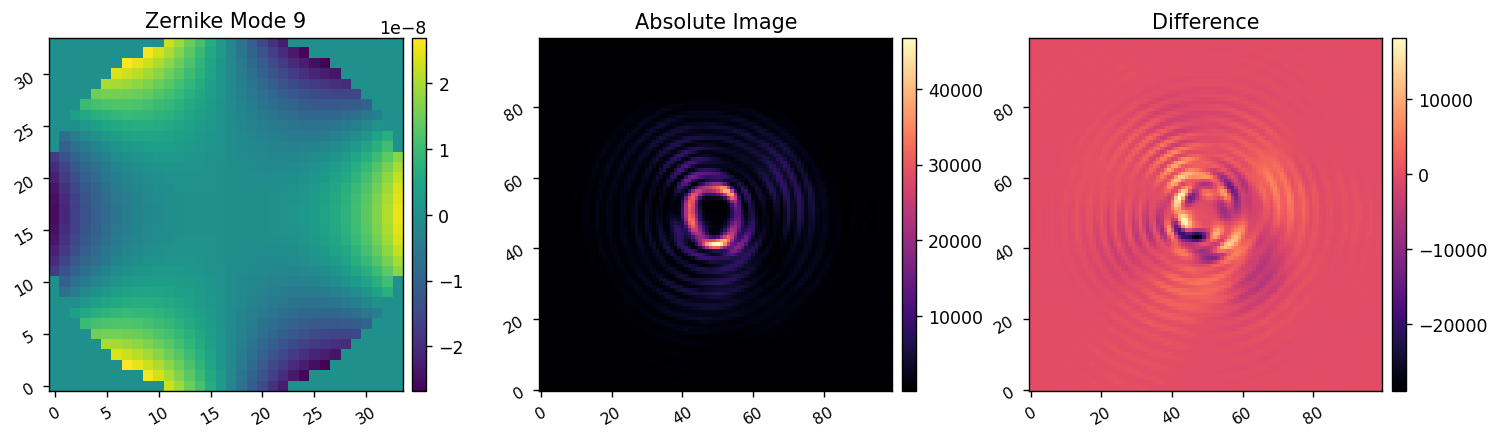

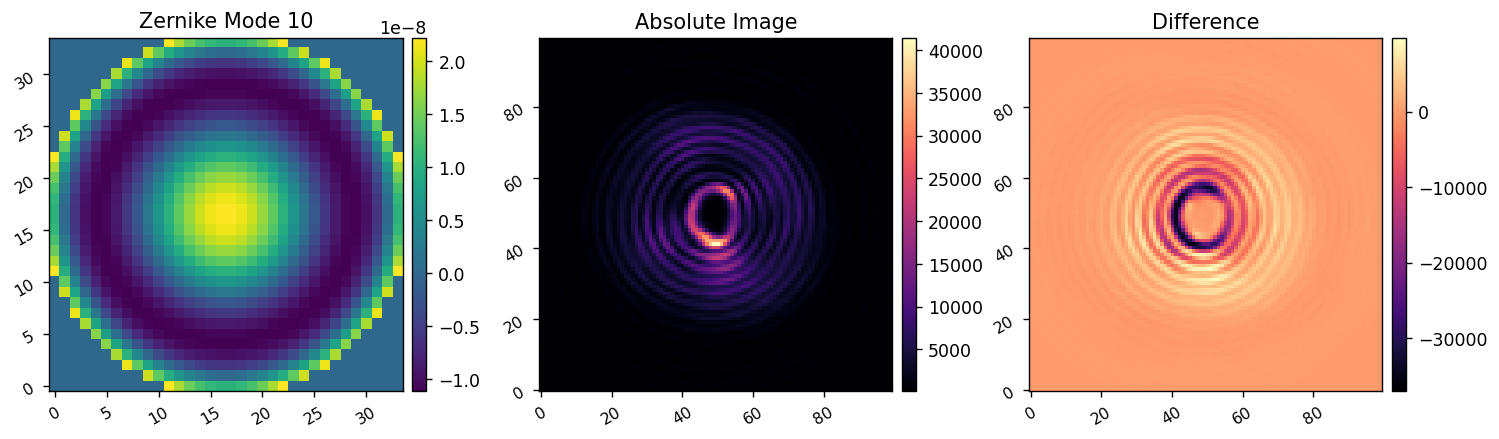

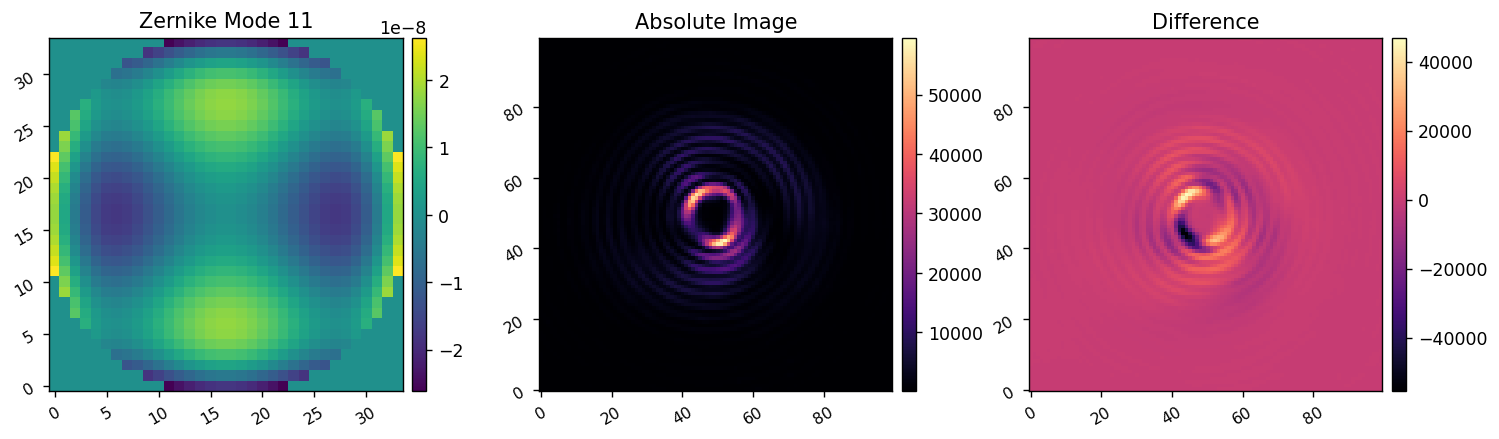

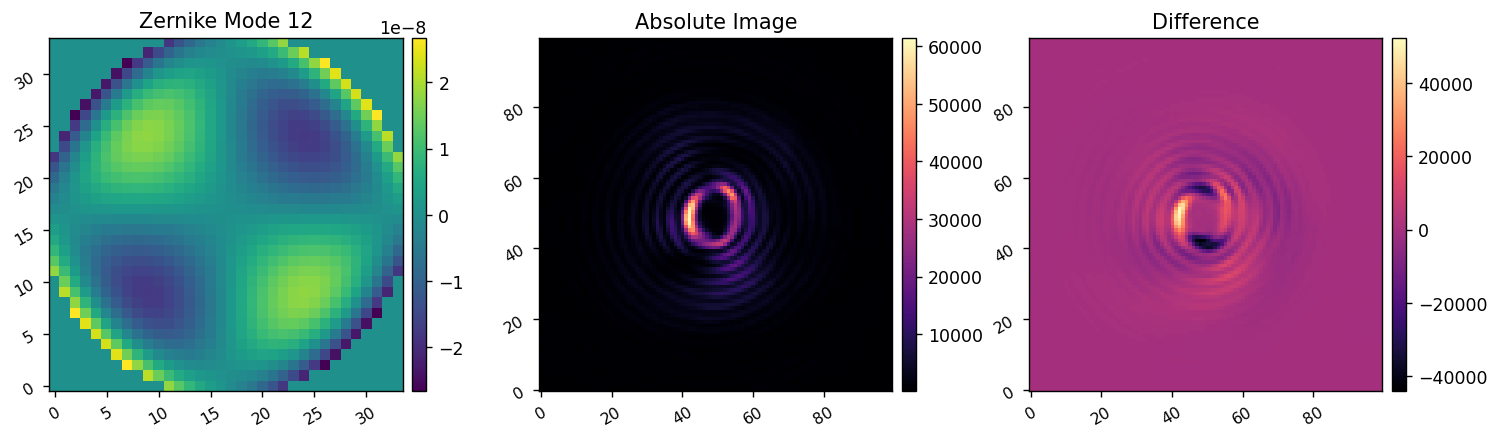

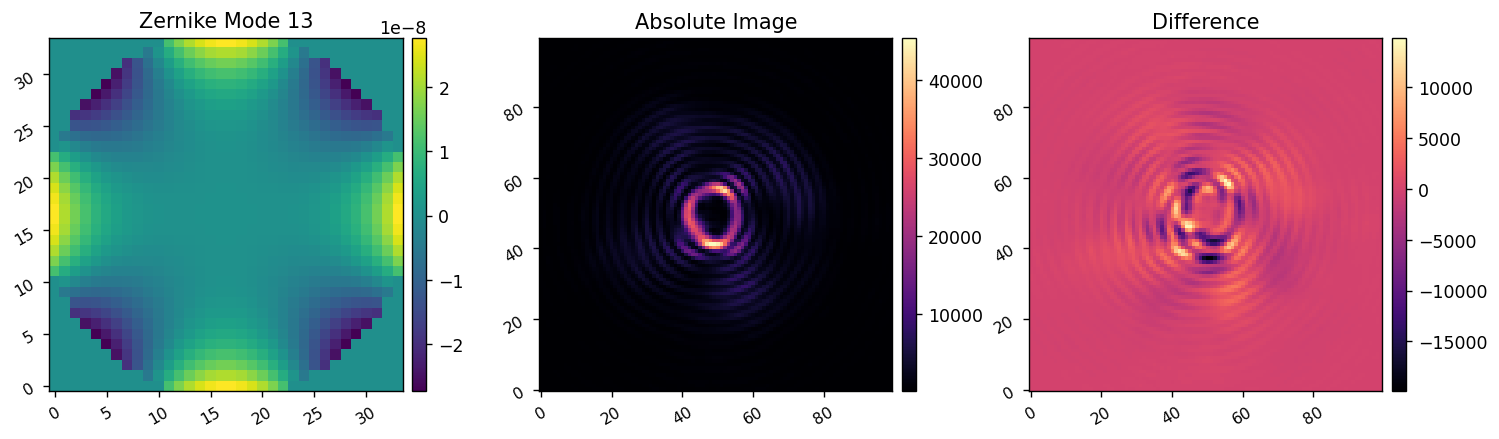

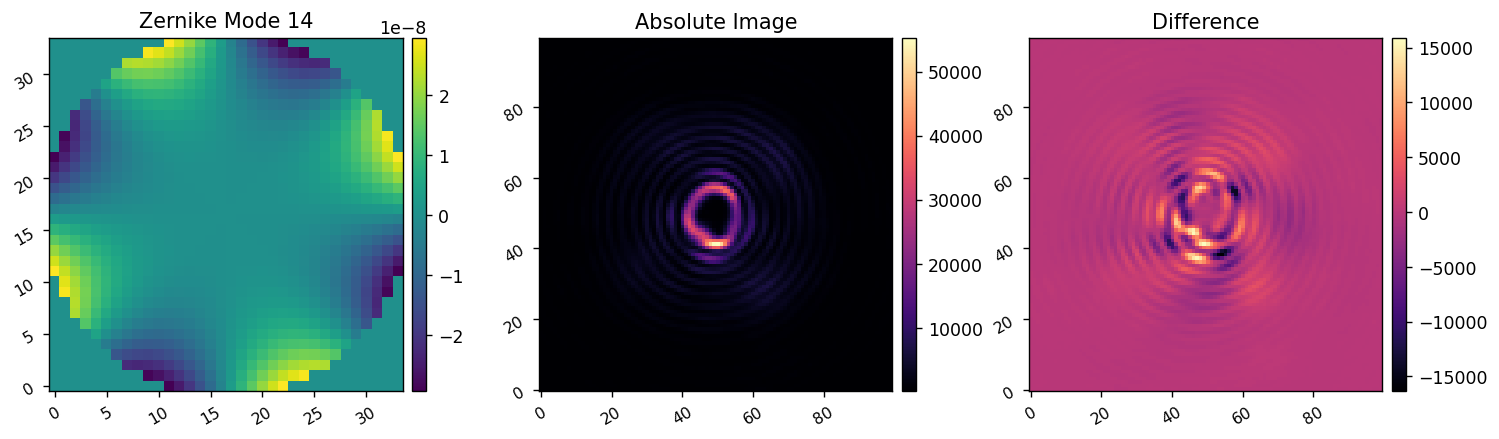

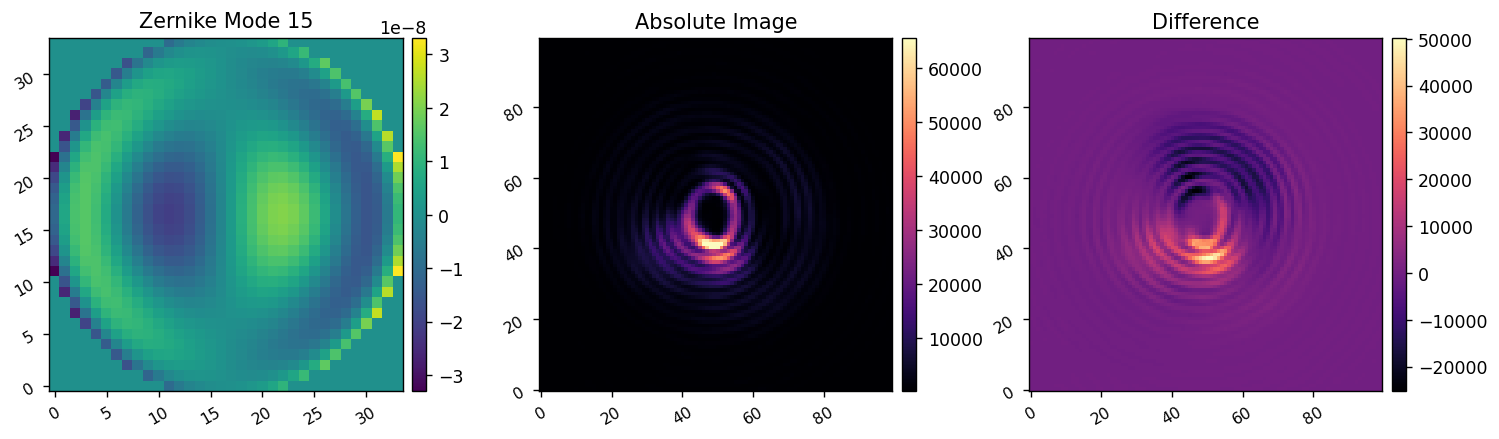

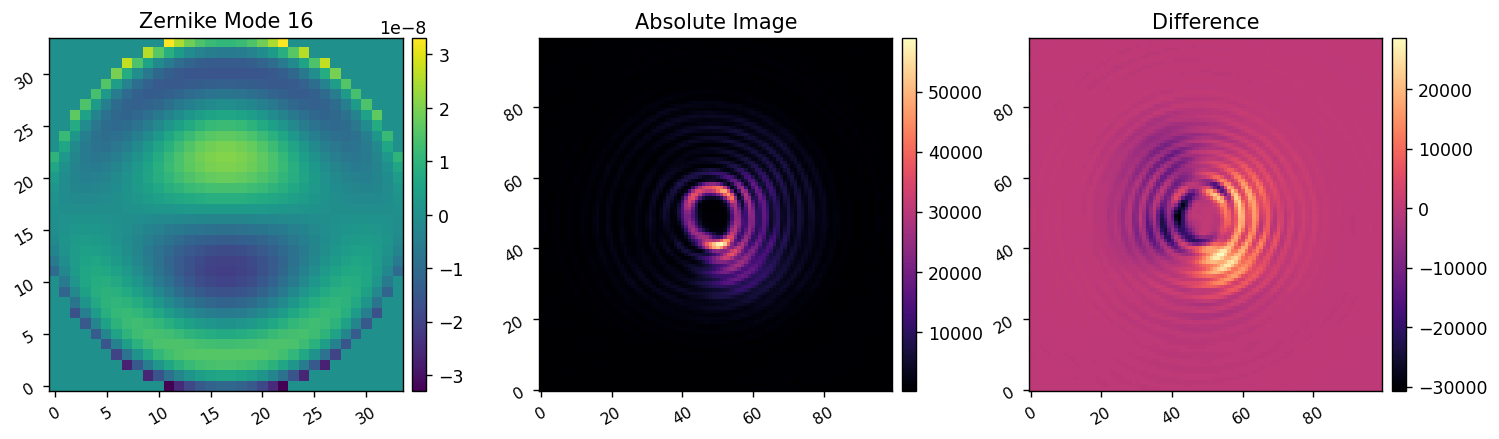

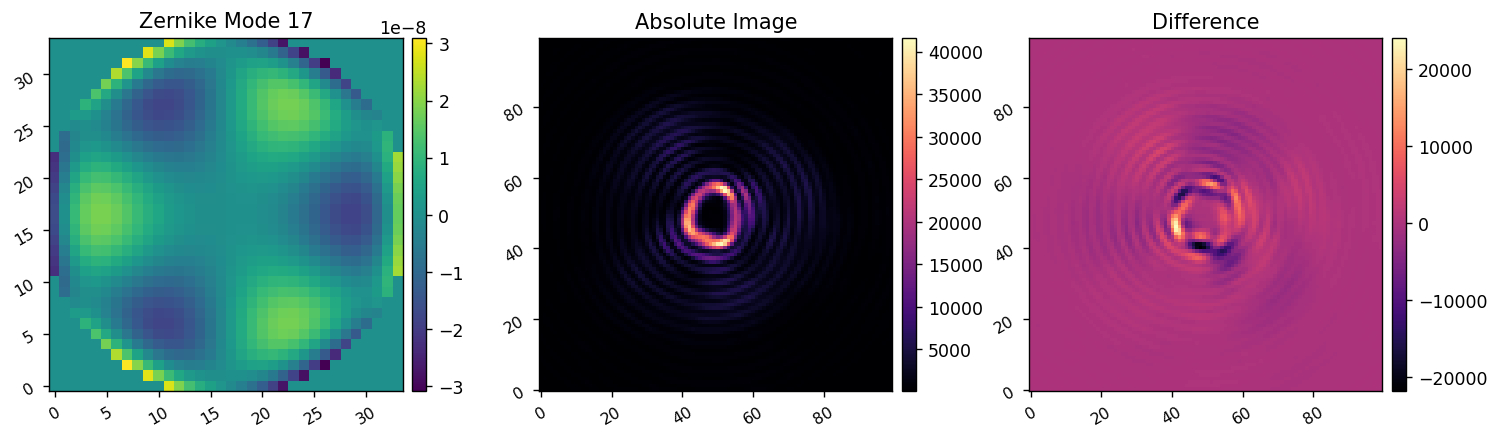

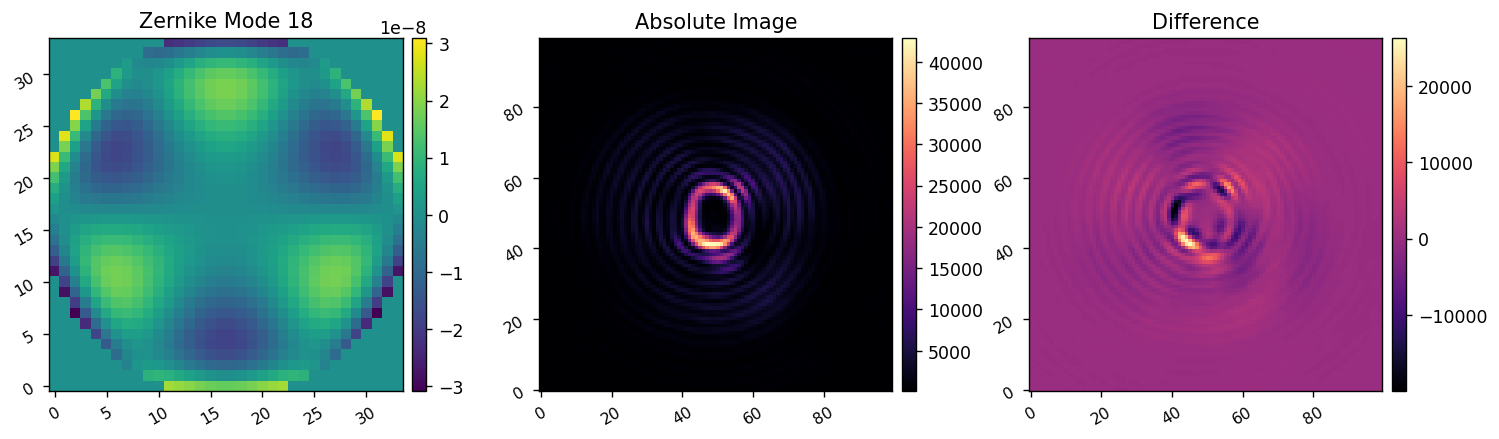

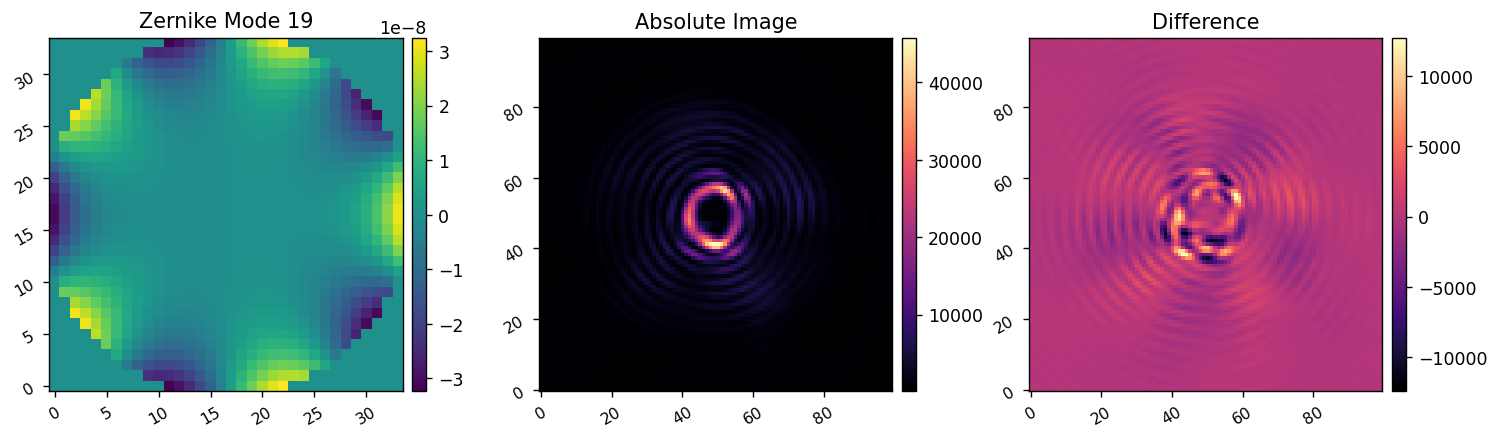

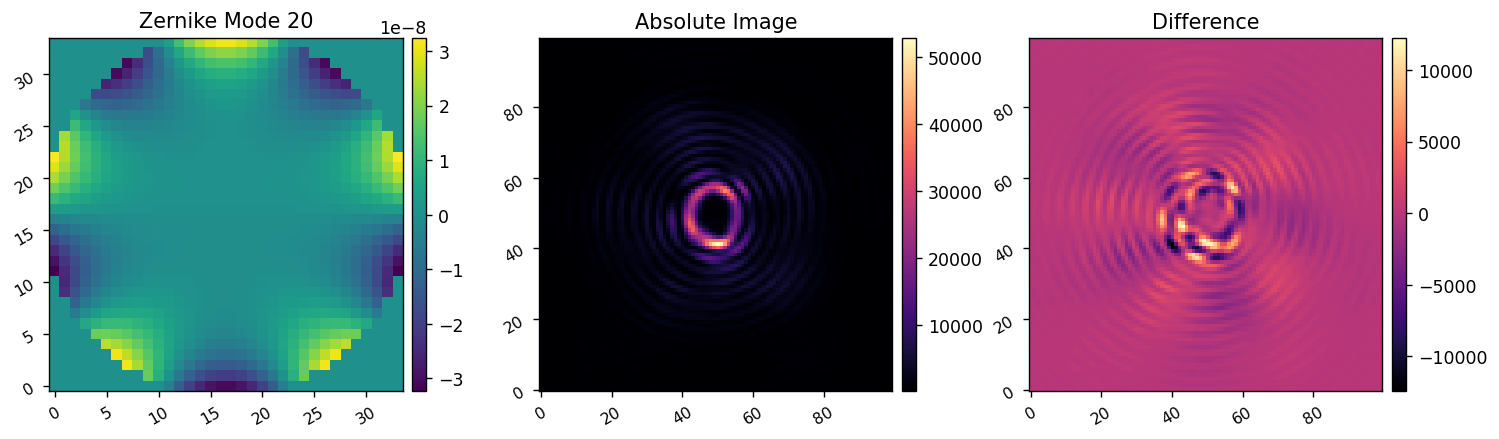

In [81]:
amp = 10e-9

I.reset_dm()
I.Nframes_locam = 5
I.return_ni_locam = True

responses = np.zeros((Nmodes, I.nlocam**2))
for i in range(Nmodes):
    mode = dm_zernikes[i]

    I.add_dm(amp*mode)
    im_pos = I.stack_locam()
    I.add_dm(-2*amp*mode)
    im_neg = I.stack_locam()
    I.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', cmap1='viridis')

response_matrix = responses.T

In [82]:
import lina
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = ensure_np_array(lina.utils.TikhonovInverse(xp.array(response_matrix), 0))

# Create the time series of WFE to inject with the DM modulator app

In [68]:
initial_jitter = 50*u.mas
dm_pupil_diam = 9.1*u.mm
total_pupil_diam = 2.4*u.m
tt_pv_to_rms = 1/4

# Recreating Chris's tip/tilt conversion from mas to nm
# initial_jitter = 96.6*u.mas
# tt_pv_to_rms = 1/4
# total_pupil_diam = 2*u.m

mag = total_pupil_diam.to_value(u.m)/dm_pupil_diam.to_value(u.m)

tt_at_dm_pupil = mag * initial_jitter
print(tt_at_dm_pupil)

tt_at_dm_pupil_pv = np.tan(tt_at_dm_pupil).value * dm_pupil_diam
print(tt_at_dm_pupil_pv.to(u.nm))

tt_at_dm_pupil_rms = tt_at_dm_pupil_pv * tt_pv_to_rms
print(tt_at_dm_pupil_rms.to(u.nm))


13186.813186813186 mas
581.7764181240618 nm
145.44410453101545 nm


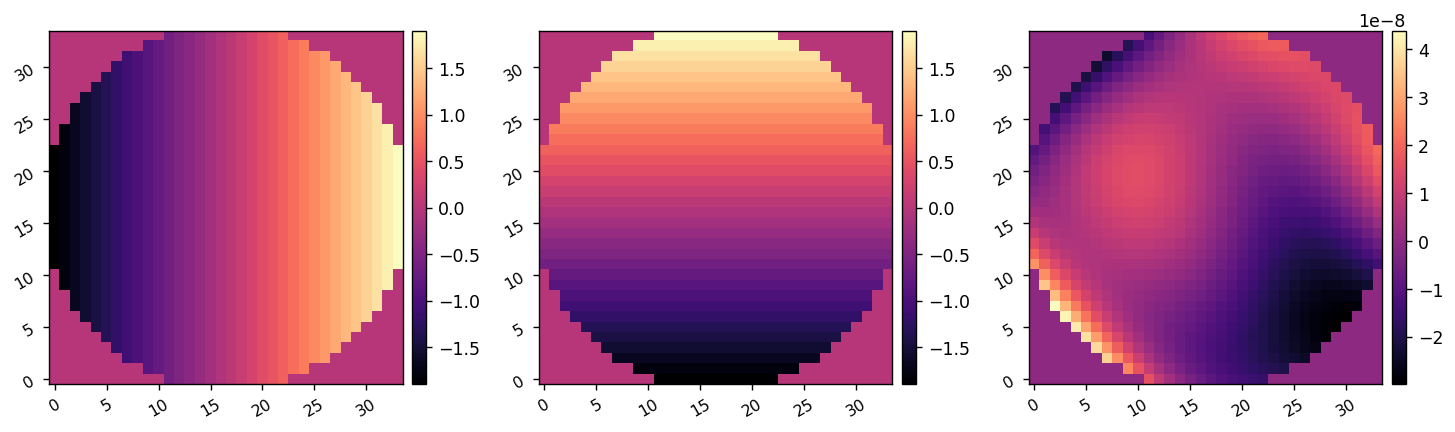

In [69]:
# wfe_modes_rms = np.array([100e-9]*2)
wfe_modes_rms = np.array([10e-9]*2 + [5e-9]*3 + [2.5e-9]*4 + [1e-9]*11)
N_wfe_modes = len(wfe_modes_rms)
wfe_modes = lina.utils.create_zernike_modes(I.dm_mask, nmodes=N_wfe_modes, remove_modes=1)

fmax = 1000*u.Hz
freqs, delF, times = psds.generate_freqs(Nf=2**18+1, f_max=fmax)

wfe_time_series = xp.zeros((N_wfe_modes+1, len(times)))
wfe_time_series[0] = xp.array(times.to_value(u.s))

slope = 4
for i in range(N_wfe_modes):
    if i<2: 
        f_knee = 0.3*u.Hz
    else: 
        f_knee = 0.05*u.Hz
    psd = psds.kneePSD(freqs, 1, f_knee, slope)
    coeff = psds.generate_time_series(psd, fmax, rms=1, seed=12345+i)
    wfe_time_series[i+1] = wfe_modes_rms[i] * xp.array(coeff)

i = 0
lo_wfe = wfe_modes.reshape(N_wfe_modes, I.Nact**2).T.dot(wfe_time_series[1:,i]).reshape(I.Nact, I.Nact)
imshow3(wfe_modes[0], wfe_modes[1], lo_wfe)

In [70]:
N = len(wfe_time_series[0])
wfe_cube = xp.zeros((N, I.Nact, I.Nact))
for i in range(N):
    wfe_cube[i] = wfe_modes.reshape(N_wfe_modes, I.Nact**2).T.dot(wfe_time_series[1:,i]).reshape(I.Nact, I.Nact)

KeyboardInterrupt: 

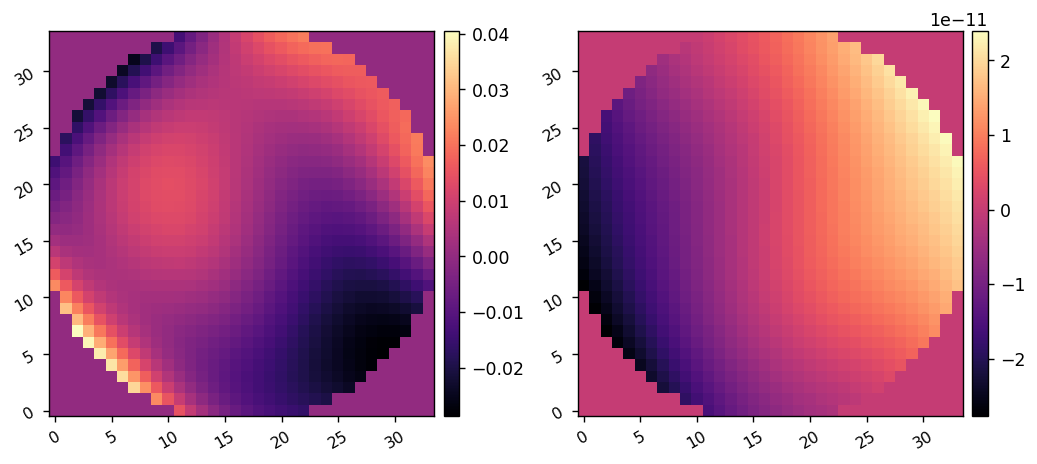

In [74]:
i = 200
imshow2(wfe_cube[i]*1e6, wfe_cube[i+1] - wfe_cube[i])

In [20]:
utils.save_fits('../data/wfe_time_series.fits', wfe_cube*1e6)

Saved data to:  ../data/wfe_time_series.fits


In [75]:
reload(scoobi)
scoobi.set_kilo_mod_amp(1, client0)

In [77]:
reload(scoobi)
scoobi.set_kilo_mod_rate(500, client0)

In [78]:
reload(scoobi)
scoobi.start_kilo_mod(client0)

In [79]:
reload(scoobi)
scoobi.stop_kilo_mod(client0)

# Define the function and process to run LLOWFSC at the desired frequency

In [96]:
def run_llowfsc_iteration(I,
                          ref_im, 
                          control_matrix, 
                          control_modes, 
                          gain=1/2,
                          thresh=0,
                          plot=True,
                          clear=True,
                          ):

    image = I.snap_locam()
    del_im = image - ref_im

    # compute the DM command with the image based on the time delayed wavefront
    modal_coeff = control_matrix.dot(del_im.flatten())
    modal_coeff *= np.abs(modal_coeff) >= thresh
    modal_coeff *= gain
    del_dm_command = -control_modes.dot(modal_coeff).reshape(I.Nact,I.Nact)
    # if reverse_dm_parity: del_dm_correction = xp.rot90(xp.rot90(del_dm_correction))
    I.add_dm(del_dm_command)

    if plot:
        dm_command = I.get_dm()
        pv_stroke = xp.max(dm_command) - xp.min(dm_command)
        rms_stroke = xp.sqrt(xp.mean(xp.square(dm_command[I.dm_mask])))
        imshow3(del_im, del_dm_command, dm_command, 
                'Measured Difference Image', 
                'Computed DM Correction',
                f'PV Stroke = {1e9*pv_stroke:.1f}nm\nRMS Stroke = {1e9*rms_stroke:.1f}nm', 
                cmap1='magma', cmap2='viridis', cmap3='viridis',
                )
        
        if clear: clear_output(wait=True)

class Process(th.Timer):  
    def run(self):  
        while not self.finished.wait(self.interval):  
            self.function(*self.args, **self.kwargs)
##We are now creating a thread timer and controling it  
# process = Repeat(0.01,print,['Repeating']) 
# process.start()
# process.cancel()

In [88]:
type(dm_zernikes)

cupy.ndarray

In [92]:
calib_modes = ensure_np_array(dm_zernikes).reshape(Nmodes, I.Nact**2).T
calib_modes.shape

(1156, 20)

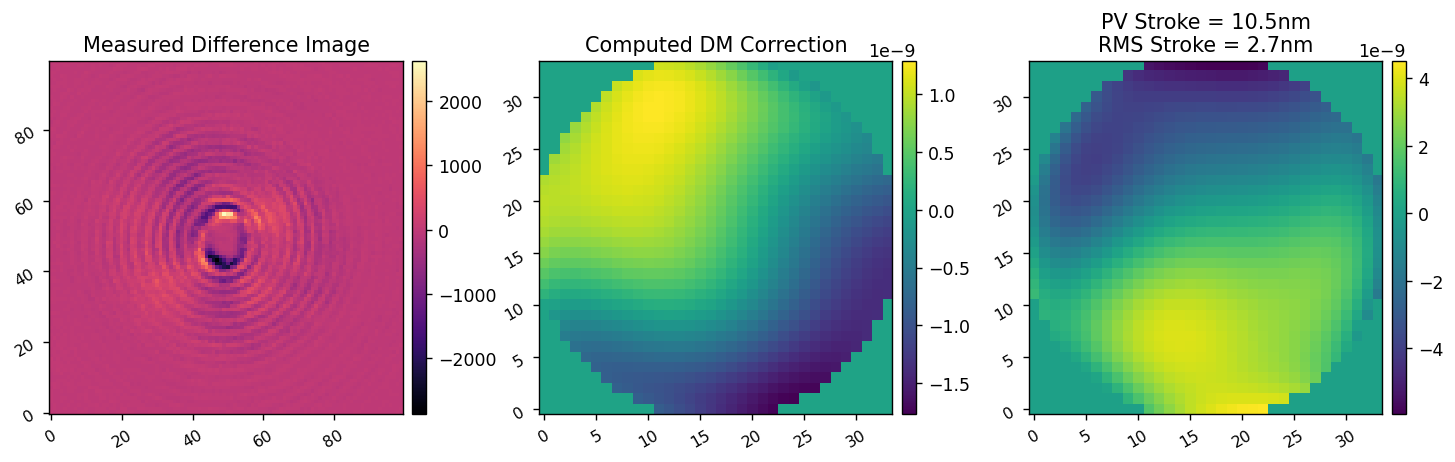

In [100]:
run_llowfsc_iteration(I, ref_im, control_matrix, calib_modes)

In [101]:
llowfsc_freq = 1
I.return_ni_locam = True
llowfsc_process = Process(1/llowfsc_freq, run_llowfsc_iteration, [I, ref_im, control_matrix, calib_modes,])


In [ ]:
reload(scoobi)
scoobi.set_kilo_mod_amp(1, client0)

In [102]:
reload(scoobi)
scoobi.set_kilo_mod_rate(200, client0)

In [103]:
reload(scoobi)
scoobi.start_kilo_mod(client0)

In [106]:
reload(scoobi)
scoobi.stop_kilo_mod(client0)

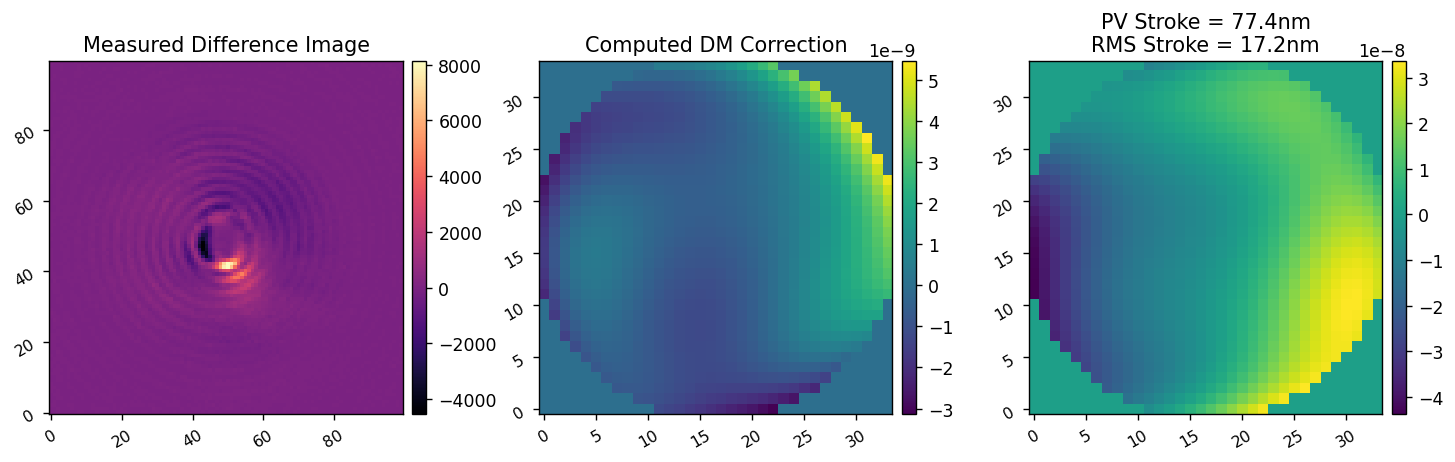

In [104]:
llowfsc_process.start()

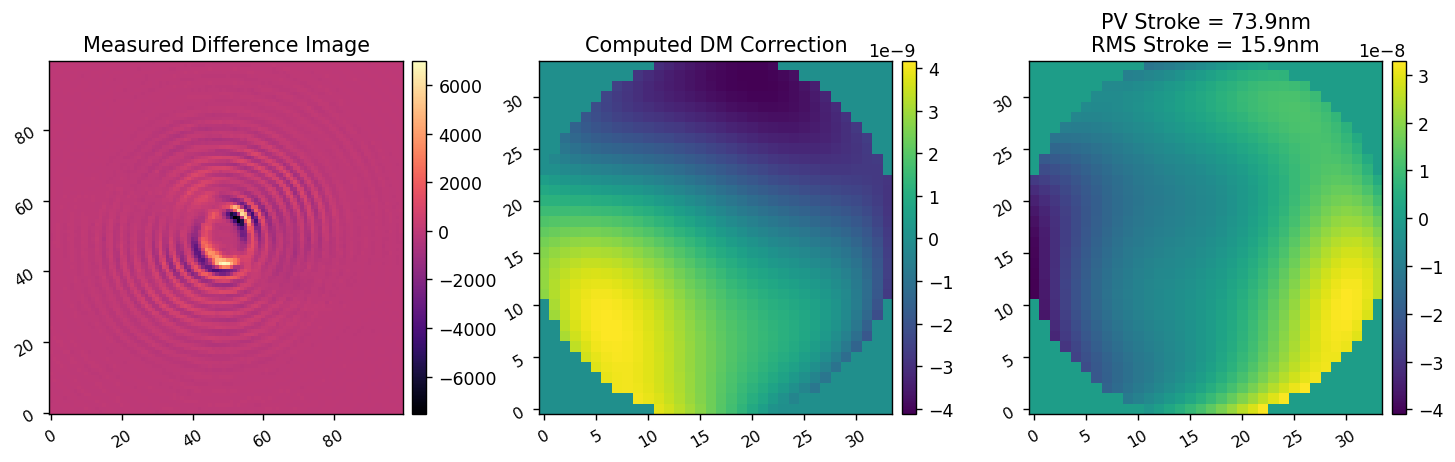

In [105]:
llowfsc_process.cancel()

In [107]:
I.reset_dm()